In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm.notebook import tqdm
import sys
import os
import json


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

def gpu_usage():
    print('gpu usage (current/max): {:.2f} / {:.2f} GB'.format(torch.cuda.memory_allocated()*1e-9, torch.cuda.max_memory_allocated()*1e-9))

In [3]:
#load data
#from torch.utils.data import Dataset, DataLoader

data_path='../../Learn2Reg_Dataset_release_v1.0/NLST/'

#write dataloader

import os
import json
import nibabel as nib

class NLST(torch.utils.data.Dataset):
    def __init__(self, root_dir, masked=True, downsampled=False):
        """
        NLST_Dataset
        Provides FIXED_IMG, MOVING_IMG, FIXED_KEYPOINTS, MOVING_KEYPOINTS
        """
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir,'imagesTr')
        self.keypoint_dir = os.path.join(root_dir,'keypointsTr')
        self.masked = masked
        with open(os.path.join(data_path,'NLST_dataset.json')) as f:
            self.dataset_json = json.load(f)
        self.shape = self.dataset_json['tensorImageShape']['0']
        self.H, self.W, self.D = self.shape
        self.downsampled = downsampled
        
    def __len__(self):
        return self.dataset_json['numPairedTraining']

    def get_shape(self):
        if self.downsampled:
            return [x//2 for x in self.shape]
        else:
            return self.shape
    
    def __getitem__(self, idx):
        fix_path=os.path.join(self.root_dir,self.dataset_json['training_paired_images'][idx]['fixed'])
        mov_path=os.path.join(self.root_dir,self.dataset_json['training_paired_images'][idx]['moving'])
    
        fixed_img=torch.from_numpy(nib.load(fix_path).get_fdata())
        moving_img=torch.from_numpy(nib.load(mov_path).get_fdata())
        
        fixed_kp=torch.from_numpy(np.genfromtxt(fix_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=','))
        moving_kp=torch.from_numpy(np.genfromtxt(mov_path.replace('images','keypoints').replace('nii.gz','csv'),delimiter=','))
        fixed_kp=(fixed_kp.flip(-1)/torch.tensor(self.shape))*2-1
        moving_kp=(moving_kp.flip(-1)/torch.tensor(self.shape))*2-1

        if self.masked and not self.downsampled:
            fixed_img=torch.from_numpy(nib.load(fix_path.replace('images', 'masks')).get_fdata())*fixed_img
            moving_img=torch.from_numpy(nib.load(mov_path.replace('images', 'masks')).get_fdata())*moving_img
        
        if self.downsampled:
            fixed_img=F.interpolate(fixed_img.view(1,1,self.H,self.W,self.D),size=(self.H//2,self.W//2,self.D//2),mode='trilinear').squeeze()
            moving_img=F.interpolate(moving_img.view(1,1,self.H,self.W,self.D), size=(self.H//2,self.W//2,self.D//2), mode='trilinear').squeeze()
            if self.masked:
                fixed_img*=F.interpolate(torch.from_numpy(nib.load(fix_path.replace('images', 'masks')).get_fdata()).view(1,1,self.H,self.W,self.D),size=(self.H//2,self.W//2,self.D//2),mode='nearest').squeeze()
                moving_img*=F.interpolate(torch.from_numpy(nib.load(mov_path.replace('images', 'masks')).get_fdata()).view(1,1,self.H,self.W,self.D),size=(self.H//2,self.W//2,self.D//2),mode='nearest').squeeze()

        return fixed_img, moving_img, fixed_kp, moving_kp
 

NLST_dataset=NLST(data_path, downsampled=True, masked=True)




In [4]:
H,W,D= NLST_dataset.get_shape()
img_all_fix=torch.zeros((100,1,H,W,D))
img_all_mov=torch.zeros((100,1,H,W,D))
kpts_all_fix=[]
kpts_all_mov=[]

with tqdm(total=100, file=sys.stdout) as pbar:
    for idx,value in enumerate(range(100)):
        img_all_fix[idx,0,...],img_all_mov[idx,0,...],tmp_kpts_fix, tmp_kpts_mov  = NLST_dataset[value]
        kpts_all_fix.append(tmp_kpts_fix.float())
        kpts_all_mov.append(tmp_kpts_mov.float())
        pbar.update(1)
        


  0%|          | 0/90 [00:00<?, ?it/s]

In [5]:
##plot sample
# import matplotlib.pyplot as plt
# idx=15; slice_=35
# H,W,D=NLST_dataset.get_shape()
# img_fix, img_mov, kpts_fix, kpts_mov = NLST_dataset[idx]
# kpts_fix_world=torch.round(((kpts_fix+1)/2)*torch.tensor([H,W,D]))
# kpts_fix_world=kpts_fix_world[abs(kpts_fix_world[:,1]-slice_)<2]
# plt.imshow(img_fix[:,slice_],'gray')
# plt.plot(kpts_fix_world[:,0], kpts_fix_world[:,2], 'r+')
# plt.show()


In [6]:

def get_layer(model, name):
    layer = model
    for attr in name.split("."):
        layer = getattr(layer, attr)
    return layer


def set_layer(model, name, layer):
    try:
        attrs, name = name.rsplit(".", 1)
        model = get_layer(model, attrs)
    except ValueError:
        pass
    setattr(model, name, layer)
import torchvision
resnet = torchvision.models.resnet18(pretrained=False)

In [7]:
resnet = torchvision.models.resnet18(pretrained=False)
resnet.layer4 = nn.Identity()
resnet.avgpool = nn.Identity()
resnet.maxpool = nn.MaxPool3d(2)

resnet.fc = nn.Sequential(nn.Unflatten(1,(8*32//2,28,24,28)),nn.Upsample(scale_factor=2,mode='trilinear'))

resnet.conv1 = nn.Conv2d(2,64,5,stride=1,padding=2)
resnet.layer2[0].conv1.stride = (1,1)
resnet.layer2[0].downsample[0].stride=1

count = 0; count2 = 0
for name, module in resnet.named_modules():
    if isinstance(module, nn.Conv2d):
        before = get_layer(resnet, name)
        after = nn.Conv3d(before.in_channels//2,before.out_channels//2,int(torch.tensor(before.kernel_size)[0]),stride=int(torch.tensor(before.stride).view(-1)[0]),padding=before.padding[0])
        set_layer(resnet, name, after); count += 1
    if isinstance(module, nn.BatchNorm2d):
        before = get_layer(resnet, name)
        after = nn.BatchNorm3d(before.num_features//2)
        set_layer(resnet, name, after); count2 += 1
print(count,'# Conv2d > Conv3d','and',count2,'#BatchNorms')
resnet.cuda()
print()


15 # Conv2d > Conv3d and 15 #BatchNorms



In [8]:

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Sequential(nn.Conv3d(in_channels,out_channels,3,padding=1,bias=False),\
                                   nn.InstanceNorm3d(out_channels),nn.ReLU(inplace=True))
        self.conv2 = nn.Sequential(nn.Conv3d(out_channels,out_channels,1,bias=False),\
                                   nn.InstanceNorm3d(out_channels),nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv1(x)
        return self.conv2(x)
    
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.ModuleDict({'enc1':ConvBlock(256,32),'enc2':ConvBlock(32,48),'enc3':ConvBlock(48,48),\
                                      'enc4':ConvBlock(48,64)})
        self.decoder = nn.ModuleDict({'dec1':ConvBlock(64+48,48),\
                                      'dec2':ConvBlock(48+48,48),'dec3':ConvBlock(48+32,32)})
        self.conv1 = ConvBlock(32,64)
        self.conv2 = nn.Sequential(nn.Conv3d(64,32,1,bias=False),nn.InstanceNorm3d(32),nn.ReLU(inplace=True),\
                                 nn.Conv3d(32,32,1,bias=False),nn.InstanceNorm3d(32),nn.ReLU(inplace=True),\
                                 nn.Conv3d(32,3,1))
    def forward(self, x):
        y = []
        upsample = nn.Upsample(scale_factor=2,mode='trilinear')
        for i in range(4):
            x = self.encoder['enc'+str(i+1)](x)
            if(i<3):
                y.append(x)
                x = F.max_pool3d(x,2) 
        for i in range(3):
            #if(i<3):
            x = torch.cat((upsample(x),y.pop()),1)
            x = self.decoder['dec'+str(i+1)](x)
        x = self.conv1(x)
        return upsample(self.conv2(x))

unet = UNet()
unet.cuda()
print()


In [9]:
def predict(unet,resnet,img_fix, img_mov, keypoints_fix):
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            resnet.eval()
            input = torch.cat((resnet(img_fix),resnet(img_mov)),1).cuda()
            output = unet(input)
            pred_xyz = F.grid_sample(output,keypoints_fix.cuda().view(1,-1,1,1,3),mode='bilinear').squeeze().t()
    return pred_xyz

In [10]:
idx_train = torch.arange(90)

H,W,D = NLST_dataset.get_shape()

#single evaluation
img_val_fix, img_val_mov, kpt_val_fix, kpt_val_mov = NLST_dataset[95]
img_val_fix=img_val_fix.float().cuda().view(1,1,H,W,D)
img_val_mov=img_val_mov.float().cuda().view(1,1,H,W,D)

optimizer = torch.optim.Adam(list(unet.parameters())+list(resnet.parameters()),lr=0.001)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,250,0.5)
t0 = time.time()
run_tre = torch.empty(0,2)
run_loss = torch.zeros(1000)
batchsz=4


with tqdm(total=1000, file=sys.stdout) as pbar:
    for i in range(1000):
        ii = idx_train[torch.randperm(len(idx_train))[:4]]
        
        img_fix = img_all_fix[ii].cuda().half()
        img_mov = img_all_mov[ii].cuda().half()
        resnet.train()
        scheduler.step()
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            input = torch.cat((resnet(img_fix),resnet(img_mov)),1).cuda()
            output = unet(input)
            loss = 0
            for j in range(4):
                keypts_fix = kpts_all_fix[int(ii[j])].cuda()
                keypts_mov = kpts_all_mov[int(ii[j])].cuda()
                disp_gt = keypts_mov-keypts_fix

                sample_xyz = kpts_all_fix[int(ii[j])].half()
                pred_xyz = F.grid_sample(output[j:j+1],sample_xyz.cuda().view(1,-1,1,1,3),mode='bilinear').squeeze().t()
                loss += nn.MSELoss()(pred_xyz,disp_gt)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        run_loss[i] = loss.item()
        run_mean = 1000*run_loss[i-20:i].mean().item()
        
        #validate TRE
        if(i%5==4):
            
            disp_gt = (kpt_val_mov-kpt_val_fix).cuda()
            tre0 = disp_gt.mul(torch.tensor([H,W,D]).view(1,3).cuda()).pow(2).sum(1).sqrt().mean().item()*1.5
            pred_xyz = predict(unet,resnet,img_val_fix,img_val_mov,kpt_val_fix.half())
            tre1 = (disp_gt-pred_xyz).cpu().mul(torch.tensor([H,W,D]).view(1,3)).pow(2).sum(1).sqrt().mean().item()*1.5
            
            run_tre = torch.cat((run_tre,torch.tensor([tre0,tre1]).view(1,2)),0)
        tre_mean = run_tre[-6:].mean(0)
        
        str1 = f"iter: {i}, loss: {run_mean:.3f}, tre0: {tre_mean[0]:.3f}, tre1: {tre_mean[1]:.3f}"
        pbar.set_description(str1)
        pbar.update(1)


  0%|          | 0/1000 [00:00<?, ?it/s]

/share/data_supergrover1/grossbroehmer/miniconda3/envs/nnunet/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/share/data_supergrover1/grossbroehmer/miniconda3/envs/nnunet/lib/python3.10/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [11]:

unet.cpu()
torch.save(unet,'NLST_Example_unet_trained.pth')
resnet.cpu()
torch.save(resnet,'NLST_Example_resnet_trained.pth')
resnet.cuda()
unet.cuda()
print()

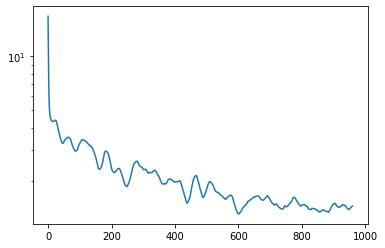

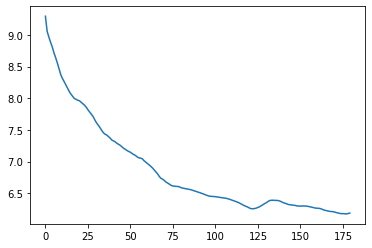

In [12]:
import matplotlib.pyplot as plt
plt.semilogy(1000*F.avg_pool1d(F.avg_pool1d(run_loss.view(1,1,-1),21,stride=1),21,stride=1).squeeze())
plt.show()
plt.plot(F.avg_pool1d(F.avg_pool1d(run_tre[:,1].view(1,1,-1),11,stride=1),11,stride=1).squeeze())
plt.show()